In [727]:
import pandas as pd
from tueplots import bundles
from tueplots.constants.color import rgb
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import joypy

```python
    # example of set plot stylesheet 
    plt.rcParams.update(bundles.icml2023(column='full', nrows=1, ncols=2, usetex=False))

    plt.savefig('figname_cml.pdf')

``````

# load data as csv files

In [511]:
dMonday = pd.read_csv(r'/Users/danielbischoff/Library/CloudStorage/OneDrive-UTCloud/Documents - Dateien von Philipp Langsteiner/Data_literacy_mensa/Mensa_data_time_formated/080124Monday.csv')
dTuesday = pd.read_csv(r'/Users/danielbischoff/Library/CloudStorage/OneDrive-UTCloud/Documents - Dateien von Philipp Langsteiner/Data_literacy_mensa/Mensa_data_time_formated/090124Tuesday.csv')
dWednesday = pd.read_csv(r'/Users/danielbischoff/Library/CloudStorage/OneDrive-UTCloud/Documents - Dateien von Philipp Langsteiner/Data_literacy_mensa/Mensa_data_time_formated/100124Wednesday.csv')
dThursday = pd.read_csv(r'/Users/danielbischoff/Library/CloudStorage/OneDrive-UTCloud/Documents - Dateien von Philipp Langsteiner/Data_literacy_mensa/Mensa_data_time_formated/110124Thursday.csv')
dFriday = pd.read_csv(r'/Users/danielbischoff/Library/CloudStorage/OneDrive-UTCloud/Documents - Dateien von Philipp Langsteiner/Data_literacy_mensa/Mensa_data_time_formated/120124Friday.csv')

## Change data types and reasure right loaded csv

In [512]:
def changeDataTypes(data):

    data['frame.time'] = pd.to_datetime(data['frame.time'], format='ISO8601')
    data = data.drop('Unnamed: 0', axis=1)
    data = data.reset_index(drop=True)

    return data

In [513]:
dMonday = changeDataTypes(dMonday)
dTuesday = changeDataTypes(dTuesday)
dWednesday = changeDataTypes(dWednesday)
dThursday = changeDataTypes(dThursday)
dFriday = changeDataTypes(dFriday)

# filter data to keep only requested data

In [514]:
# filter for devices that comunicate with an cisco router
def filter(data):
    # data = data.copy()
    eduroam_ssid = '656475726f616d'

    # The ^ tell the regular expression, that it start with the pattern that follows
    cisco_pattern = '^' + '00:f6:63:'

    d_dpa = data.loc[data['_ws.col.protocol'] == 'EAP']

    # Authentication with all cisco devices
    df_dpa_cisco = d_dpa.loc[d_dpa['wlan.sa'].str.match(cisco_pattern)]

    # Authenticated mac addresses as a list
    dpa_cisco_list = df_dpa_cisco['wlan.da'].unique().tolist()

    # All data filterd for eduroam, UTGuest and Guest
    df = data.loc[(data["wlan.ssid"] == eduroam_ssid)|(data["wlan.ssid"] == "55546775657374" )|( data["wlan.ssid"] =="4775657374")]

    # all unique mac addresses with the ssids
    all_sources = df["wlan.sa"].unique().tolist()

    # Combination of mac addresses of the ssids and EPA
    combined_macs = list(set(all_sources + dpa_cisco_list))
    print(f"Number of unqiue mac addresses verfied by cisco: {df_dpa_cisco['wlan.da'].nunique()}")

    # Drop NaNs and sort for time
    data.dropna(subset=['wlan.sa'], inplace = True)
    data['wlan.ssid'].value_counts().sort_index(inplace=True)

    # All entries that use the resulting mac addresses
    return data.loc[data['wlan.sa'].isin(combined_macs)]

In [516]:
# use filter method
dFilteredMonday  = filter(dMonday)
dFilteredTuesday  = filter(dTuesday)
dFilteredWednesday  = filter(dWednesday)
dFilteredThursday  = filter(dThursday)
dFilteredFriday  = filter(dFriday)

Number of unqiue mac addresses verfied by cisco: 995
Number of unqiue mac addresses verfied by cisco: 329
Number of unqiue mac addresses verfied by cisco: 1189
Number of unqiue mac addresses verfied by cisco: 757
Number of unqiue mac addresses verfied by cisco: 413


# Create Dataframe first and last seen

In [517]:
dFirstMonday = dFilteredMonday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastMonday = dFilteredMonday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstTuesday = dFilteredTuesday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastTuesday = dFilteredTuesday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstWednesday = dFilteredWednesday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastWednesday = dFilteredWednesday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstThursday = dFilteredThursday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastThursday = dFilteredThursday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()
dFirstFriday = dFilteredFriday.drop_duplicates(subset='wlan.sa', keep='first').sort_index()
dLastFriday = dFilteredFriday.drop_duplicates(subset='wlan.sa', keep='last').sort_index()

# Create Dataframe count of first and last seen add

In [518]:
dCountFirstMonday = pd.DataFrame(dFirstMonday['frame.time'].value_counts().sort_index())
dCountLastMonday = pd.DataFrame(dLastMonday['frame.time'].value_counts().sort_index())
dCountFirstTuesday = pd.DataFrame(dFirstTuesday['frame.time'].value_counts().sort_index())
dCountLastTuesday = pd.DataFrame(dLastTuesday['frame.time'].value_counts().sort_index())
dCountFirstWednesday = pd.DataFrame(dFirstWednesday['frame.time'].value_counts().sort_index())
dCountLastWednesday = pd.DataFrame(dLastWednesday['frame.time'].value_counts().sort_index())
dCountFirstThursday = pd.DataFrame(dFirstThursday['frame.time'].value_counts().sort_index())
dCountLastThursday = pd.DataFrame(dLastThursday['frame.time'].value_counts().sort_index())
dCountFirstFriday = pd.DataFrame(dFirstFriday['frame.time'].value_counts().sort_index())
dCountLastFriday = pd.DataFrame(dLastFriday['frame.time'].value_counts().sort_index())

# Create Dataframe count of frist and last sean mac add every x min

In [501]:
# dCountFirstTuesday.reset_index(inplace=True)
# dCountLastTuesday.reset_index(inplace=True)

In [522]:
def ResampleToXTime(periode, data):

    # Set 'time' column as index
    # data.set_index('frame.time', inplace=True)

    # Resample and sum up 'count' every x minutes
    resampled_data = data.resample(periode + 'Min').sum()

    # # Reset index
    resampled_data.reset_index(inplace=True)

    return resampled_data

In [525]:
d5CountFirstMonday = ResampleToXTime('5', dCountFirstMonday)
d5CountLastMonday = ResampleToXTime('5', dCountLastMonday)
d5CountFirstTuesday = ResampleToXTime('5', dCountFirstTuesday)
d5CountLastTuesday = ResampleToXTime('5', dCountLastTuesday)
d5CountFirstWednesday = ResampleToXTime('5', dCountFirstWednesday)
d5CountLastWednesday = ResampleToXTime('5', dCountLastWednesday)
d5CountFirstThursday = ResampleToXTime('5', dCountFirstThursday)
d5CountLastThursday = ResampleToXTime('5', dCountLastThursday)
d5CountFirstFriday = ResampleToXTime('5', dCountFirstFriday)
d5CountLastFriday = ResampleToXTime('5', dCountLastFriday)

In [624]:
def getCumSum(dataFirst, dataLast):
    data = dataLast.copy()
    data['count'] = np.cumsum(dataFirst['count'] - dataLast['count'])
    data['count'] = np.cumsum(dataFirst['count']) - np.cumsum(dataLast['count'])

    return data

## create week dataset

In [692]:
d5CumSumMonday = getCumSum(d5CountFirstMonday, d5CountLastMonday)
d5CumSumTuesday = getCumSum(d5CountFirstTuesday, d5CountLastTuesday)
d5CumSumWednesday = getCumSum(d5CountFirstWednesday, d5CountLastWednesday)
d5CumSumThursday = getCumSum(d5CountFirstThursday, d5CountLastThursday)
d5CumSumFriday = getCumSum(d5CountFirstFriday, d5CountLastFriday)

d5CumSumWeek = pd.concat([d5CumSumMonday, d5CumSumTuesday, d5CumSumWednesday, d5CumSumThursday, d5CumSumFriday])

In [526]:
#  only keeps the time of data frames
def keepOnlyTime(data):
    data = data.copy()
    data['frame.time'] = data['frame.time'].dt.time.astype(str)
    data["frame.time"] = data["frame.time"].str.replace(r':\d{2}$', '', regex=True)

    return data

In [527]:
# convert to only keep time in string format
d5timeCountFirstMonday = keepOnlyTime(d5CountFirstMonday).sort_index()
d5timeCountLastMonday = keepOnlyTime(d5CountLastMonday).sort_index()
d5timeCountFirstTuesday = keepOnlyTime(d5CountFirstTuesday).sort_index()
d5timeCountLastTuesday = keepOnlyTime(d5CountLastTuesday).sort_index()
d5timeCountFirstWednesday = keepOnlyTime(d5CountFirstWednesday).sort_index()
d5timeCountLastWednesday = keepOnlyTime(d5CountLastWednesday).sort_index()
d5timeCountFirstThursday = keepOnlyTime(d5CountFirstThursday).sort_index()
d5timeCountLastThursday = keepOnlyTime(d5CountLastThursday).sort_index()
d5timeCountFirstFriday = keepOnlyTime(d5CountFirstFriday).sort_index()
d5timeCountLastFriday = keepOnlyTime(d5CountLastFriday).sort_index()

# Plot Results


In [604]:
# Merge all dataframes and rename the count columns
def rename_merge(dataframes, suffixes):
    for i in range(len(dataframes)):
        dataframes[i].rename(columns={'count': f'count_{suffixes[i]}'}, inplace=True)

    merge_df = dataframes[0]

    for dataframe in dataframes[1:]:
        merge_df = merge_df.merge(dataframe, how='outer', on='frame.time')

    return merge_df.dropna()

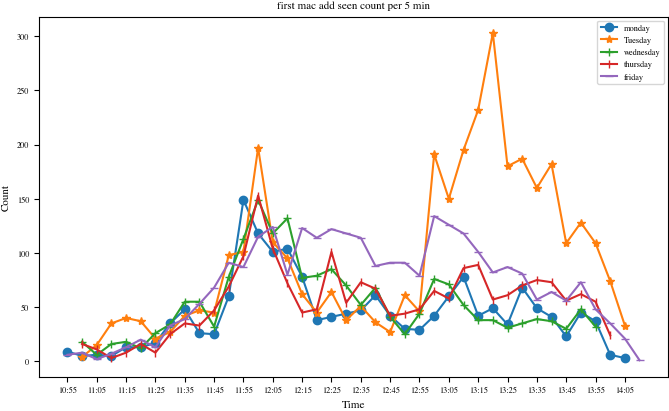

In [605]:
plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))

plt.plot(d5timeCountFirstMonday['frame.time'], d5timeCountFirstMonday['count'], marker='o', label='monday')
plt.plot(d5timeCountFirstTuesday['frame.time'], d5timeCountFirstTuesday['count'], marker='*', label='Tuesday')
plt.plot(d5timeCountFirstWednesday['frame.time'], d5timeCountFirstWednesday['count'], marker='+', label='wednesday')
plt.plot(d5timeCountFirstThursday['frame.time'], d5timeCountFirstThursday['count'], marker='|', label='thursday')
plt.plot(d5timeCountFirstFriday['frame.time'], d5timeCountFirstFriday['count'], marker='_', label='friday')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.title('first mac add seen count per 5 min')

# Get current ticks
locs, labels = plt.xticks()

# Set new ticks 
plt.xticks(locs[::2])


plt.savefig('./plots/first_seen_mac_per_5_min.pdf')

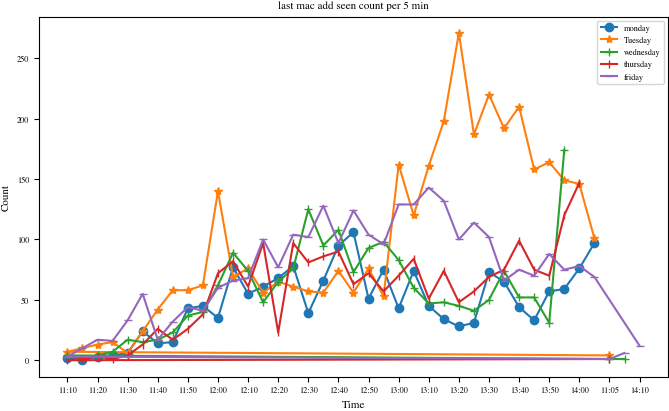

In [606]:
plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))

plt.plot(d5timeCountLastMonday['frame.time'], d5timeCountLastMonday['count'], marker='o', label='monday')
plt.plot(d5timeCountLastTuesday['frame.time'], d5timeCountLastTuesday['count'], marker='*', label='Tuesday')
plt.plot(d5timeCountLastWednesday['frame.time'], d5timeCountLastWednesday['count'], marker='+', label='wednesday')
plt.plot(d5timeCountLastThursday['frame.time'], d5timeCountLastThursday['count'], marker='|', label='thursday')
plt.plot(d5timeCountLastFriday['frame.time'], d5timeCountLastFriday['count'], marker='_', label='friday')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.title('last mac add seen count per 5 min')

# Get current ticks
locs, labels = plt.xticks()

# Set new ticks 
plt.xticks(locs[::2])

plt.savefig('./plots/last_seen_mac_per_5_min.pdf')

## Cumulative sum
subtract frist seen count from last seen count add compute the cumulative sum

In [608]:
d5CumSumMonday = getCumSum(d5timeCountFirstMonday, d5timeCountLastMonday)
d5CumSumTuesday = getCumSum(d5timeCountFirstTuesday, d5timeCountLastTuesday)
d5CumSumWednesday = getCumSum(d5timeCountFirstWednesday, d5timeCountLastWednesday)
d5CumSumThursday = getCumSum(d5timeCountFirstThursday, d5timeCountLastThursday)
d5CumSumFriday = getCumSum(d5timeCountFirstFriday, d5timeCountLastFriday)

In [609]:
d5timeCountFirstMondaySl = d5timeCountFirstMonday.iloc[1:]

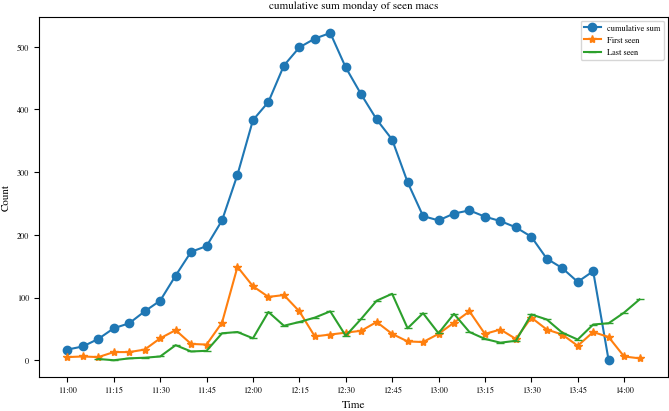

In [610]:
plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))

plt.plot(d5CumSumWednesday['frame.time'], d5CumSumWednesday['count'], marker='o', label='cumulative sum')
plt.plot(d5timeCountFirstMondaySl['frame.time'], d5timeCountFirstMondaySl['count'], marker='*', label='First seen')
plt.plot(d5timeCountLastMonday['frame.time'], d5timeCountLastMonday['count'], marker='_', label='Last seen')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.title('cumulative sum monday of seen macs')

# Get current ticks
locs, labels = plt.xticks()

# Set new ticks 
plt.xticks(locs[::3])

plt.savefig('./plots/cumSumMonday.pdf')

In [611]:
d5CumSumDaysMerged = rename_merge([d5CumSumMonday,d5CumSumTuesday,d5CumSumWednesday,d5CumSumThursday,d5CumSumFriday], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

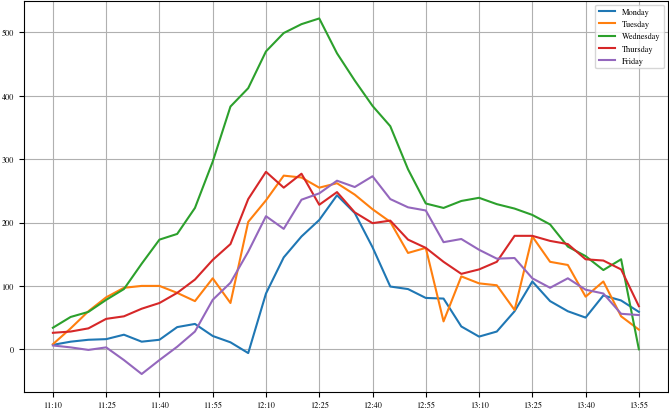

In [721]:
plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))
plt.plot(d5CumSumDaysMerged['frame.time'],d5CumSumDaysMerged['count_Monday'], label='Monday')
plt.plot(d5CumSumDaysMerged['frame.time'],d5CumSumDaysMerged['count_Tuesday'], label='Tuesday')
plt.plot(d5CumSumDaysMerged['frame.time'],d5CumSumDaysMerged['count_Wednesday'], label='Wednesday')
plt.plot(d5CumSumDaysMerged['frame.time'],d5CumSumDaysMerged['count_Thursday'], label='Thursday')
plt.plot(d5CumSumDaysMerged['frame.time'],d5CumSumDaysMerged['count_Friday'], label='Friday')
locs, labels = plt.xticks()
plt.legend()
plt.xticks(locs[::3])
plt.grid(True)
plt.savefig('./plots/cumSumWeek.pdf')
plt.show()


In [704]:
# Assuming 'frame.time' is your datetime column
d5CumSumWeek['date'] = d5CumSumWeek['frame.time'].dt.date
d5CumSumWeek['time'] = d5CumSumWeek['frame.time'].dt.time
d5CumSumWeek

,frame.time,count,date,time
0,2024-01-08 11:10:00+01:00,7.0,2024-01-08,11:10:00
1,2024-01-08 11:15:00+01:00,12.0,2024-01-08,11:15:00
2,2024-01-08 11:20:00+01:00,15.0,2024-01-08,11:20:00
3,2024-01-08 11:25:00+01:00,16.0,2024-01-08,11:25:00
4,2024-01-08 11:30:00+01:00,23.0,2024-01-08,11:30:00
...,...,...,...,...
34,2024-01-12 13:50:00+01:00,56.0,2024-01-12,13:50:00
35,2024-01-12 13:55:00+01:00,54.0,2024-01-12,13:55:00
36,2024-01-12 14:00:00+01:00,24.0,2024-01-12,14:00:00
37,2024-01-12 14:05:00+01:00,-10.0,2024-01-12,14:05:00


/usr/local/Caskroom/miniconda/base/envs/dataLiteracy/lib/python3.11/site-packages/joypy/joyplot.py:582: UserWarning: The figure layout has changed to tight
  fig.tight_layout(h_pad=h_pad)


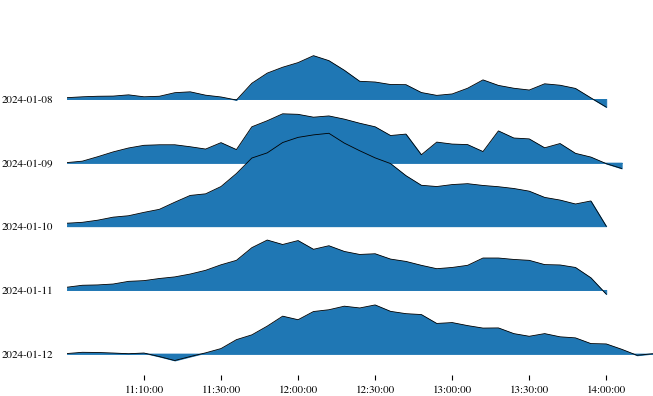

In [746]:
plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=1, usetex=False))
x_range = list(range(39))
labels = d5CumSumWeek['time'].astype(str).drop_duplicates().sort_index()

# Change the x-axis labels
fig, axes = joypy.joyplot(d5CumSumWeek, column='count', by='date', kind="values", x_range = x_range, overlap=1, linewidth=0.6)
axes[-1].set_xticklabels(labels[::6])
plt.savefig('./plots/cumSumWeekJoy.pdf')
plt.show()